In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


import warnings

warnings.filterwarnings("ignore")

In [2]:
class Config:
    '''
    Config in which I hold all hyperparameters and frequently used variables such as image shape, train directory path etc.
    '''
    def __init__(self, DEBUG=False):
        self.DEBUG = DEBUG
        
    TRAIN_CSV = 'instance-segmentation/train.csv'
    TRAIN_DIR = 'instance-segmentation/train/'
    TEST_DIR = 'instance-segmentation/test/'
    
    IMG_SHAPE = (512, 512)
    
    LR = 1e-3
    
    EPOCHS = 100
    
    N_FILTERS = 32

    
    BATCH_SIZE = 4
    AUTOTUNE = tf.data.AUTOTUNE
    
    N_CLASSES = 1
    BUFFER_SIZE = 2
    
    val_size = 0.1
    
    WEIGHTS_PATH = os.path.join('./', 'model.h5')
        
    seed = 123
    

config = Config()

# Data Loading And Exploration

First lets load <code>train.csv</code> to pandas dataframe and take a look at out data

In [3]:
train_csv = pd.read_csv(Config.TRAIN_CSV)
train_csv.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


First thing I've noticed is that the same ID appears several times with different annotations, it means that each annotation is only for one cell, and that the annotations might overlap 

**Let's take a look at a single image**

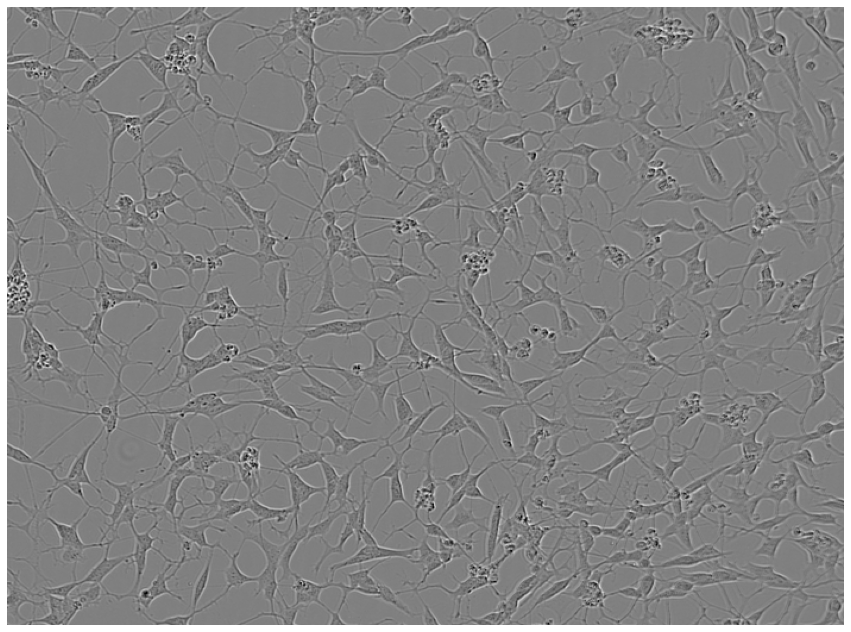

In [4]:
plt.figure(figsize=(15,15))

plt.imshow(cv2.imread(config.TRAIN_DIR + '0030fd0e6378' + '.png'))
plt.axis("off")
plt.show()

Knowing that ids might appear several times let's see how large our dataset is

In [5]:
train_csv.shape

(73585, 9)

But how large is it when we take into the account that id is unique?

In [6]:
train_csv["id"].unique().shape

(606,)

Let's see how our dataframe looks for a single id

In [7]:
train_csv[train_csv['id'] == '0030fd0e6378']

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
390,0030fd0e6378,264628 3 265328 8 266028 12 266729 15 267432 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
391,0030fd0e6378,268853 4 269553 10 270255 12 270958 12 271661 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
392,0030fd0e6378,2095 1 2798 3 3501 5 4203 7 4906 9 5609 10 631...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
393,0030fd0e6378,105571 3 106274 5 106978 5 107682 6 108386 6 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [8]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels, input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height, width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

# Data Vizualization

Now knowing how to load our data we can finally see how the annotations for neuronal cells look like

Let's see how many classes there are for the <code>cell_type</code> column and what the distribution looks like

In [9]:
train_csv["cell_type"].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

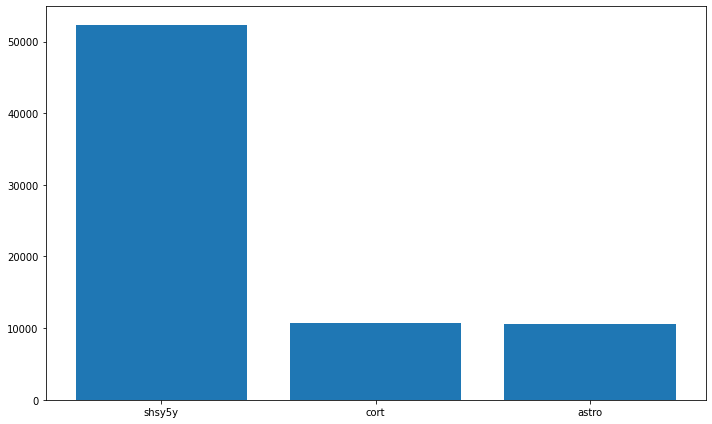

In [10]:
cell_types = train_csv["cell_type"].value_counts()

plt.figure(figsize=(10, 6), tight_layout=True)

plt.bar(cell_types.index, cell_types.values)
plt.show()

The distribution is clearly skewed, **shsy5y** cell images domminate the dataset, this might cause our model to have worse performance on other cell types

Data augmentation should be performed on the dataset in order to fight this issue

In [11]:
shy5y_sample = train_csv[train_csv['cell_type'] == 'shsy5y'].sample(2)['id']
cort_sample = train_csv[train_csv['cell_type'] == 'cort'].sample(2)['id']
astro_sample = train_csv[train_csv['cell_type'] == 'astro'].sample(2)['id']

**Let's see how the annotations look like**

In [12]:
def display_sample(sample_ids, n_samples=2, hspace=-0.6):
    '''
    Function to visualize images and their annotations
    
    sample_ids - list of ids
    n_samples - number of samples to display
    hspace - parameter for matplotlib, it contorls spacing between images 
    '''
    fig, axs = plt.subplots(n_samples, 3, figsize=(22, 25))
    
    for idx, sample_id in enumerate(sample_ids):
        sample_image = cv2.imread(os.path.join(config.TRAIN_DIR + sample_id + '.png'))
        
        sample_rles = train_csv.loc[train_csv['id'] == sample_id]['annotation'].values
        
        sample_mask_colors = build_masks(sample_rles, (520, 704), colors=True)
        sample_mask = build_masks(sample_rles, (520, 704), colors=False)
        
        axs[idx][0].imshow(sample_image)
        axs[idx][0].axis('off')        
        
        axs[idx][1].imshow(sample_mask_colors)        
        axs[idx][1].axis('off')        
        
        axs[idx][2].imshow(sample_mask)
        axs[idx][2].axis('off')        

    axs[0][0].set_title("Image", fontsize=16)
    axs[0][1].set_title("Mask Color", fontsize=16)
    axs[0][2].set_title("Mask", fontsize=16)

    fig.subplots_adjust(hspace=hspace)
    plt.show()       

**SHY5Y**

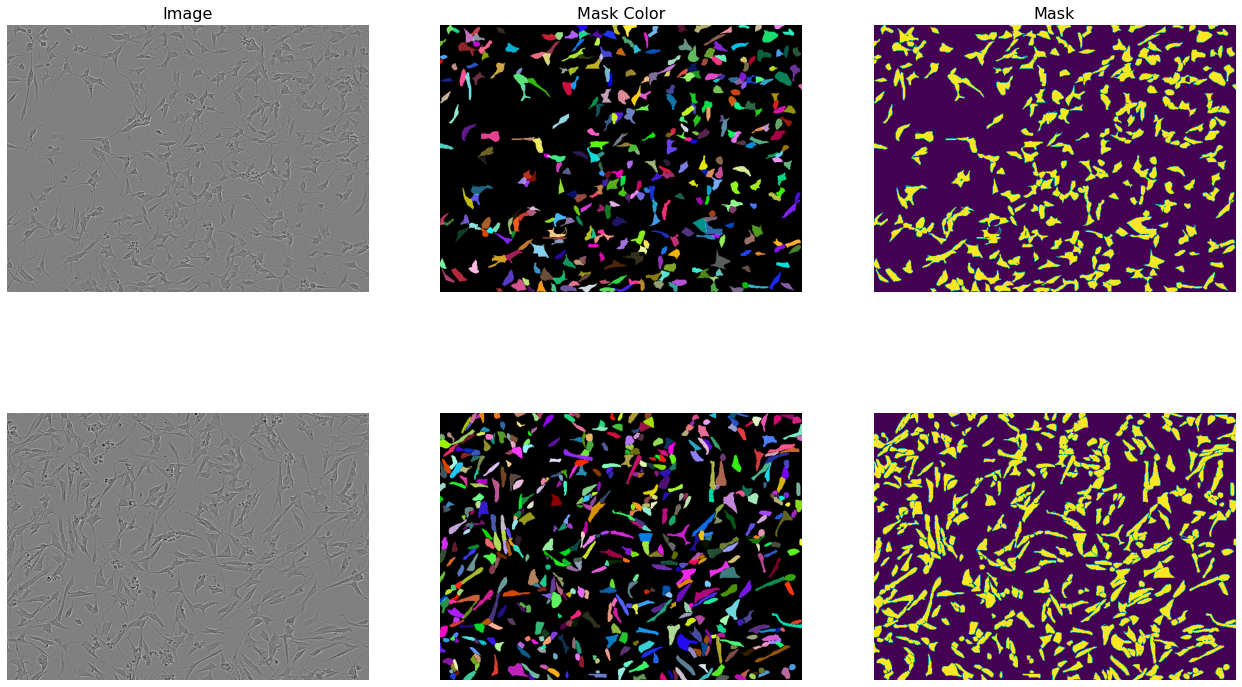

In [13]:
display_sample(shy5y_sample)

**CORT**

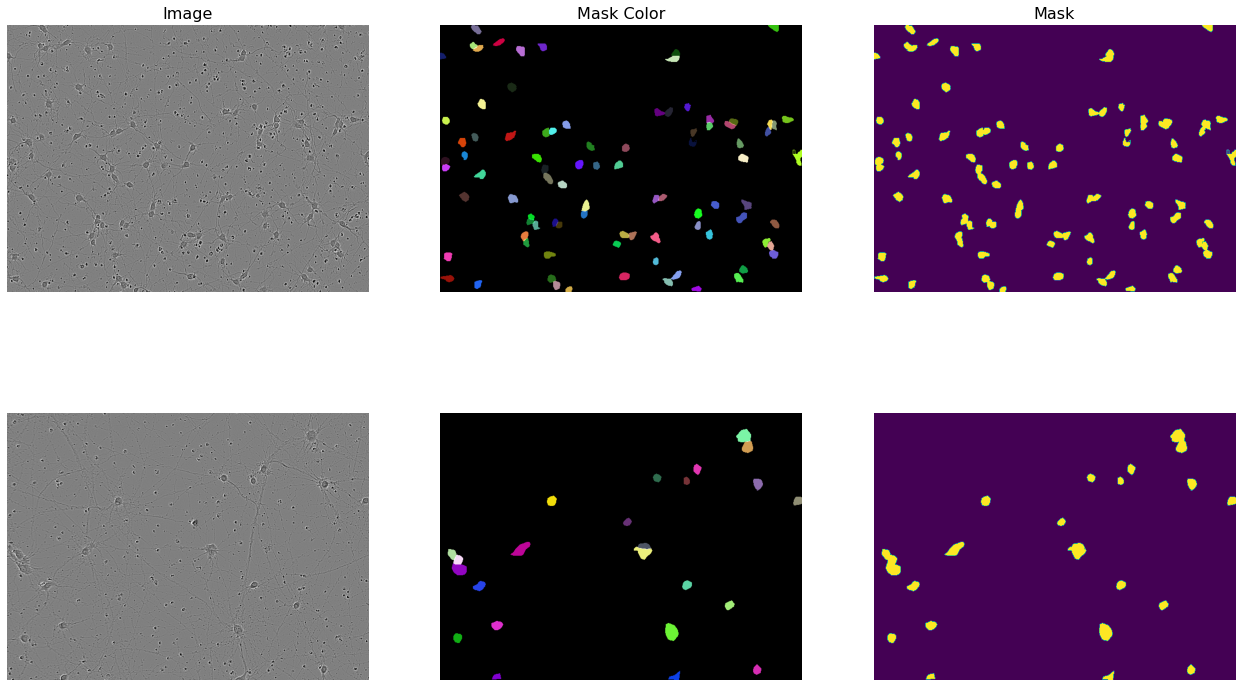

In [14]:
display_sample(cort_sample)

**ASTRO**

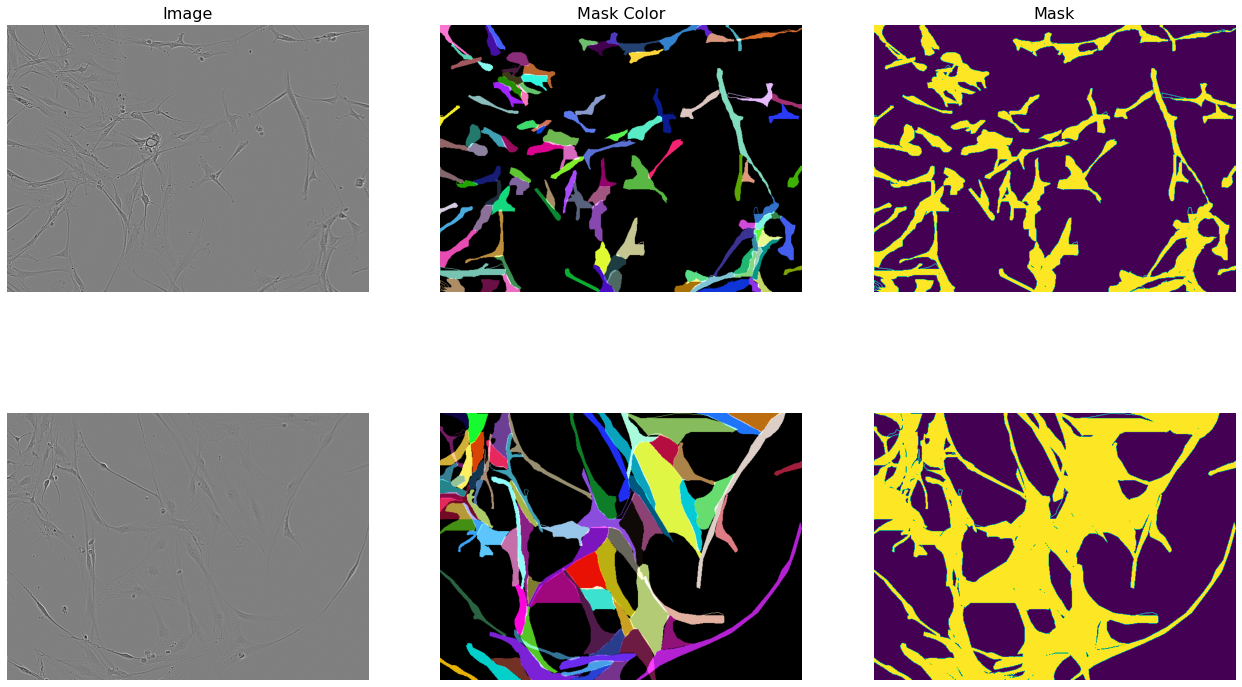

In [15]:
display_sample(astro_sample)

# Preparing training and validation datasets



In [16]:
ids = train_csv['id'].unique()

train_ids, val_ids = train_test_split(ids, test_size=config.val_size, random_state=config.seed)

In [17]:
train_ids.shape

(545,)

In [18]:
def load_train_ds():
    '''
    This function creates a generator for train dataset
    '''
    for image_id in train_ids:
        rows = train_csv.loc[train_csv['id'] == image_id]
        image = tf.io.read_file(config.TRAIN_DIR + image_id + '.png')
        image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
        rles = rows['annotation'].values

        mask = build_masks(rles, (520, 704), colors=False)
        mask = tf.cast(tf.image.resize(mask, config.IMG_SHAPE), tf.int32)

        image = tf.image.resize(image, config.IMG_SHAPE)
        image /= 255.0
    
        yield image, mask
        
        
def load_val_ds():
    '''
    This function creates a generator for train dataset
    '''
    for image_id in val_ids:
        rows = train_csv.loc[train_csv['id'] == image_id]
        image = tf.io.read_file(config.TRAIN_DIR + image_id + '.png')
        image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
        rles = rows['annotation'].values

        mask = build_masks(rles, (520, 704), colors=False)
        mask = tf.cast(tf.image.resize(mask, config.IMG_SHAPE), tf.int32)

        image = tf.image.resize(image, config.IMG_SHAPE)
        image /= 255.0
    
        yield image, mask

In [19]:
train_ds = tf.data.Dataset.from_generator(
    load_train_ds, 
    output_types=(tf.float32, tf.int32)
)

val_ds = tf.data.Dataset.from_generator(
    load_val_ds, 
    output_types=(tf.float32, tf.int32)
)

2021-12-25 15:29:31.876563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 15:29:32.005000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 15:29:32.005749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 15:29:32.008135: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

As I've mentioned before the dataset is severly inbalanced which can cause our model to perform worse in some cases. One popular and simple method to fight this problem is **data augmentation**.

**Data Augmentation** is a method to artifically expand dataset by slightly modifing existing data in a realistic way, for my case I will flip the images horizontally and vertically


In [20]:
def augment_ds(image, mask):
    image = tf.image.random_flip_up_down(image, seed=config.seed)
    mask = tf.image.random_flip_up_down(mask, seed=config.seed)
    
    image = tf.image.random_flip_left_right(image, seed=config.seed)
    mask = tf.image.random_flip_left_right(mask, seed=config.seed)
    
    return image, mask

In [21]:
train_ds = (
    train_ds
    .shuffle(config.BUFFER_SIZE)
    .map(augment_ds)
    .batch(config.BATCH_SIZE)    
    .prefetch(Config.AUTOTUNE)
)

val_ds = val_ds.batch(config.BATCH_SIZE)

2021-12-25 15:29:35.180817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


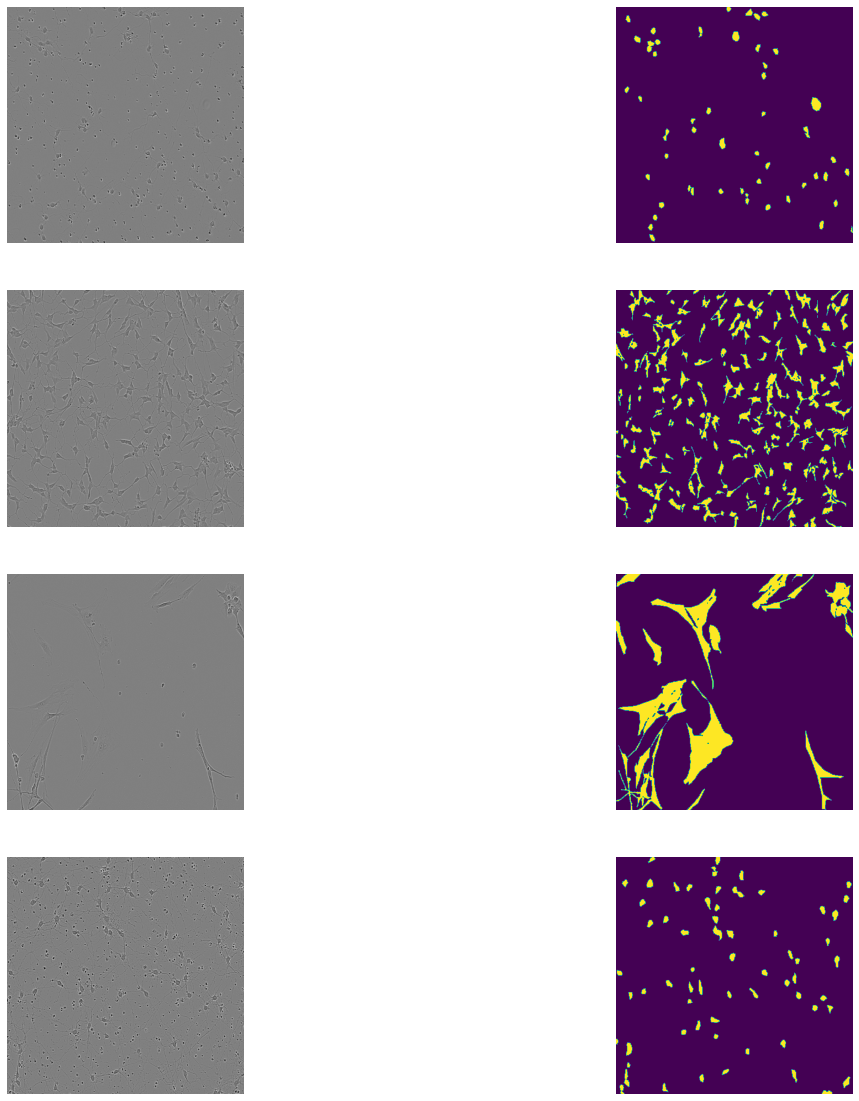

In [22]:
sample_batch = next(iter(train_ds))

images, masks = sample_batch

fig, ax = plt.subplots(config.BATCH_SIZE, 2, figsize=(20, 20))

for i in range(config.BATCH_SIZE):
    ax[i][0].imshow(images[i] * 255)
    ax[i][0].axis('off')        
    
    ax[i][1].imshow(masks[i])    
    ax[i][1].axis('off')        

plt.show()

# Modeling



In [23]:
def attention(input_tensor, g, inter_shape):    
    input_shapes = input_tensor.shape
    g_shapes = g.shape
    
    x = tf.keras.layers.Conv2D(inter_shape, 1, 2, padding="same")(input_tensor)
    g = tf.keras.layers.Conv2D(inter_shape, 1, padding="same")(g)


    add = tf.keras.layers.add([x, g])
    relu = tf.keras.layers.Activation('relu')(x)
    
    psi = tf.keras.layers.Conv2D(1, 1, padding="same")(relu)
    sigmoid = tf.keras.layers.Activation('sigmoid')(psi)
    
    upsample = tf.keras.layers.UpSampling2D(size=(2, 2))(sigmoid)
    
    att = tf.keras.layers.multiply([upsample, input_tensor])
    
    output = tf.keras.layers.Conv2D(input_shapes[3], 1, padding="same")(att)
    return tf.keras.layers.BatchNormalization()(output)

def conv_block(input_tensor, n_filters, dropout=0.5, batch_norm=True):
    x_save = tf.keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same")(input_tensor)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x_save)
    
    x = tf.keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same")(x)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    
    if dropout:
        x = tf.keras.layers.Dropout(dropout)(x)
            
    x = tf.keras.layers.add([x, x_save])
    x = tf.keras.layers.Activation("relu")(x)

    return x

def downsample(x, n_filters, dropout=0.5, batch_norm=True):
    res_conn = conv_block(x, n_filters, dropout=dropout, batch_norm=batch_norm)
    
    x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(res_conn)
    
    return x, res_conn

def upsample(x, n_filters, skip_conn, dropout=0.5, batch_norm=True):
    att = attention(skip_conn, x, n_filters)
    x = tf.keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding="same", activation="relu")(x)
    x = tf.keras.layers.Concatenate()([x, att])
    x = conv_block(x, n_filters)
    
    if dropout:
        x = tf.keras.layers.Dropout(dropout)(x)

    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    return x
    
def create_model(n_filters):
    inputs = tf.keras.layers.Input(shape=(*Config.IMG_SHAPE, 3))
    
    x, skip_conn1 = downsample(inputs, n_filters)
    x, skip_conn2 = downsample(x, n_filters * 2)
    x, skip_conn3 = downsample(x, n_filters * 4)
    x, skip_conn4 = downsample(x, n_filters * 8)
    
    x = conv_block(x, n_filters * 16)

    x = upsample(x, n_filters * 8, skip_conn4)
    x = upsample(x, n_filters * 4, skip_conn3)    
    x = upsample(x, n_filters * 2, skip_conn2)    
    x = upsample(x, n_filters, skip_conn1)
    
    outputs = tf.keras.layers.Conv2D(config.N_CLASSES, 3, activation="sigmoid", padding="same")(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [24]:
model = create_model(config.N_FILTERS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [25]:
def dice_loss(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)

metrics = [iou_coef]
model.compile(optimizer=optimizer, loss=dice_loss, metrics=metrics)

# Training


In [27]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    config.WEIGHTS_PATH,
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
    monitor="val_loss",
    mode="min"
)

rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.01, 
    patience=5, 
    min_delta=1e-2
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-2, 
    patience=15, 
    verbose=1,
    mode='min',
)

In [28]:
history = model.fit(
    train_ds, 
    epochs=config.EPOCHS, 
    validation_data=val_ds,
    callbacks=[cp_callback, rlr_callback, es_callback]
)

Epoch 1/100


2021-12-25 15:29:44.863348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


137/137 [==============================] - 93s 581ms/step - loss: 0.3960 - iou_coef: 0.2550 - val_loss: 0.9540 - val_iou_coef: 0.0147

Epoch 00001: val_loss improved from inf to 0.95399, saving model to ./model.h5
Epoch 2/100
137/137 [==============================] - 72s 525ms/step - loss: 0.3334 - iou_coef: 0.3378 - val_loss: 0.9773 - val_iou_coef: 0.0086

Epoch 00002: val_loss did not improve from 0.95399
Epoch 3/100
137/137 [==============================] - 72s 522ms/step - loss: 0.3032 - iou_coef: 0.3687 - val_loss: 0.9967 - val_iou_coef: 0.0017

Epoch 00003: val_loss did not improve from 0.95399
Epoch 4/100
137/137 [==============================] - 73s 529ms/step - loss: 0.2780 - iou_coef: 0.3823 - val_loss: 0.7726 - val_iou_coef: 0.0477

Epoch 00004: val_loss improved from 0.95399 to 0.77258, saving model to ./model.h5
Epoch 5/100
137/137 [==============================] - 72s 519ms/step - loss: 0.2602 - iou_coef: 0.3998 - val_loss: 0.8230 - val_iou_coef: 0.0955

Epoch 00005: 

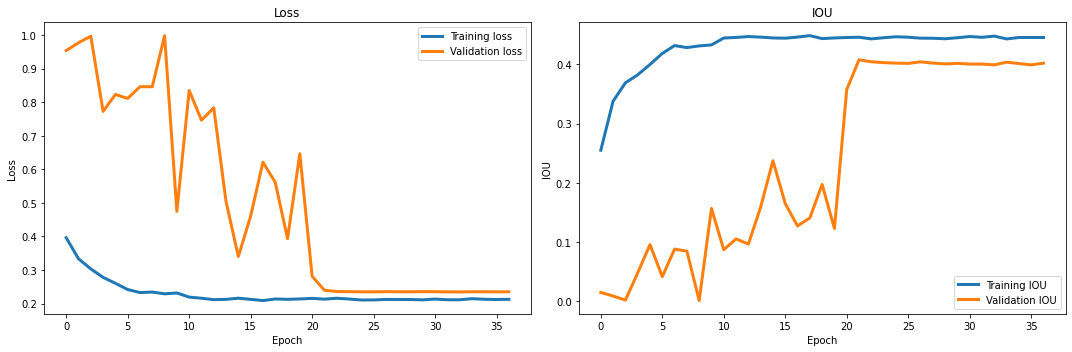

In [29]:
history_dict = history.history

fig, ax = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

ax[0].plot(history_dict['loss'], label="Training loss", linewidth=3)
ax[0].plot(history_dict['val_loss'], label="Validation loss", linewidth=3)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(history_dict['iou_coef'], label="Training IOU", linewidth=3)
ax[1].plot(history_dict['val_iou_coef'], label="Validation IOU", linewidth=3)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("IOU")
ax[1].set_title("IOU")
ax[1].legend()

plt.show()

# Testing

In [30]:
# Get the best model

model.load_weights(config.WEIGHTS_PATH)

In [31]:
test_ids = os.listdir(config.TEST_DIR)

def load_test_ds():
    for image_id in test_ids:
        image = tf.io.read_file(os.path.join(config.TEST_DIR, image_id))         
        image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
        image = tf.image.resize(image, config.IMG_SHAPE)
        image /= 255.0
        yield image
        
test_ds = (
    tf.data.Dataset.from_generator(
        load_test_ds, 
        output_types=tf.float32
    )
    .batch(3)
)

In [32]:
preds = model.predict(test_ds)

In [33]:
preds = (preds > 0.5).astype(np.int32)

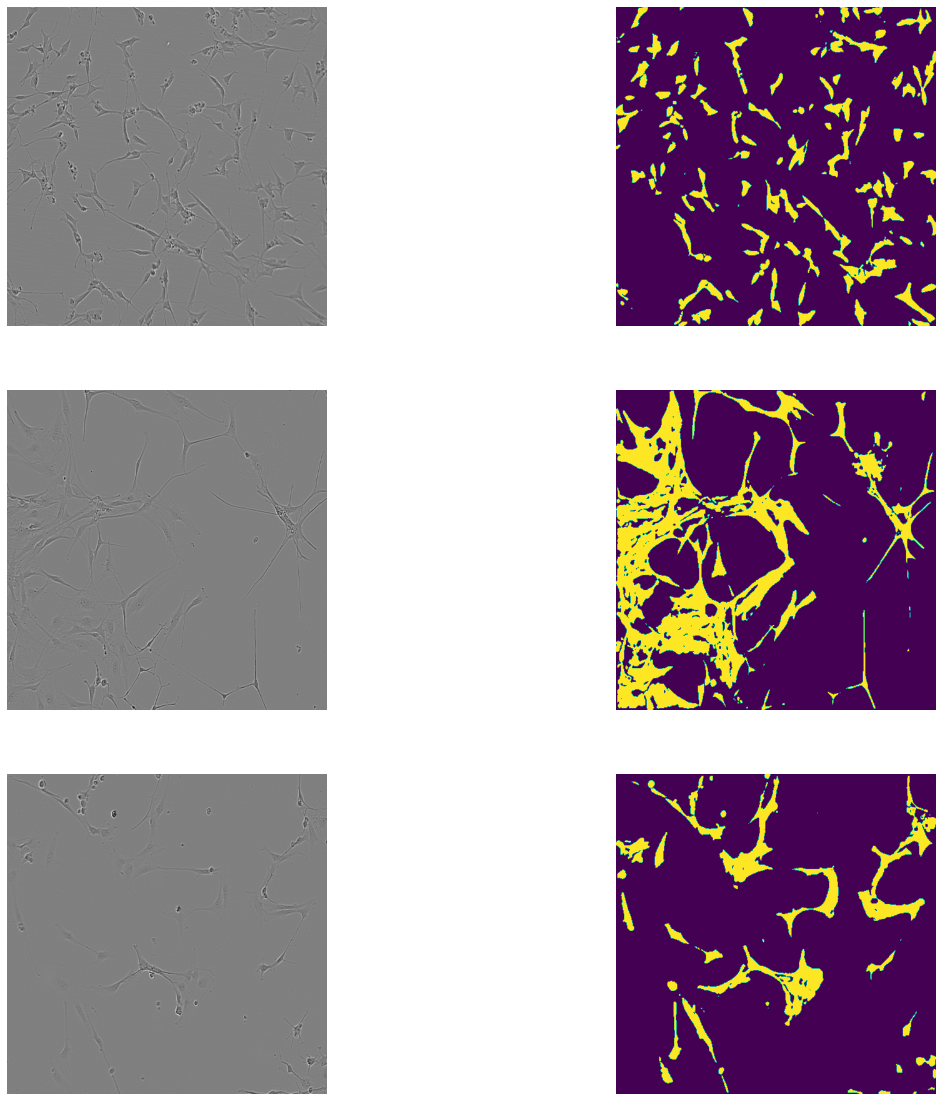

In [34]:
test_iter = next(iter(test_ds))

fig, ax = plt.subplots(3, 2, figsize=(20, 20))

for i in range(3):
    ax[i][0].imshow(test_iter[i] * 255)
    ax[i][0].axis('off')        
    
    ax[i][1].imshow(preds[i])
    ax[i][1].axis('off')        
        
plt.show()